# 음료 여부 검증 모델 학습

이 노트북은 용기 이미지를 **음료 있음(has_beverage)** vs **비어있음(empty)**으로 분류하는 모델을 학습합니다.

## 데이터셋 구조
```
data_preprocessed/has_beverage/
├── has_beverage/  (음료 있음)
├── empty/         (비어있음)
└── unclear/       (불명확 - 학습에서 제외)
```

## 모델 아키텍처
- **베이스 모델**: EfficientNet-B0 (ImageNet pretrained)
- **분류**: Binary classification (has_beverage vs empty)
- **데이터 증강**: 회전, 뒤집기, 밝기 조정 등

## 1. 환경 설정 및 라이브러리 import

In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 2060
Memory: 6.01 GB


## 🔧 GPU 메모리 관리 (필요시 사용)

학습 중 GPU 메모리 부족 시 아래 셀을 실행하세요.

In [12]:
# GPU 메모리 유틸리티 import
import sys
sys.path.append('/app')
from notebooks.gpu_memory_utils import clear_gpu_memory, print_gpu_memory

# 현재 GPU 메모리 상태 확인
print_gpu_memory()

# GPU 메모리 정리 (필요시 주석 해제)
clear_gpu_memory()

GPU 0: NVIDIA GeForce RTX 2060
Total Memory:     5730.12 MB
Allocated:        1412.17 MB (24.6%)
Reserved:         1434.00 MB (25.0%)
Free:             4317.95 MB (75.4%)
GPU Memory Cleanup
Before cleanup:
  Allocated: 1412.17 MB
  Reserved:  1434.00 MB

After cleanup:
  Allocated: 1412.17 MB (freed: 0.00 MB)
  Reserved:  1434.00 MB (freed: 0.00 MB)


{'before': {'allocated': 1412.17236328125, 'reserved': 1434.0},
 'after': {'allocated': 1412.17236328125, 'reserved': 1434.0},
 'freed': {'allocated': 0.0, 'reserved': 0.0}}

## 2. 하이퍼파라미터 설정

In [3]:
# 경로 설정
DATA_DIR = Path('/app/data_preprocessed/has_beverage')
MODEL_SAVE_DIR = Path('/app/models/weights')
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# 학습 하이퍼파라미터
BATCH_SIZE = 16  # GPU 메모리 절약을 위해 감소
IMG_SIZE = 224
EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
TRAIN_RATIO = 0.8
PATIENCE = 10  # Early stopping patience

# 클래스 정의 (unclear는 제외)
CLASSES = ['empty', 'has_beverage']
NUM_CLASSES = len(CLASSES)

print(f"Data directory: {DATA_DIR}")
print(f"Model save directory: {MODEL_SAVE_DIR}")
print(f"Classes: {CLASSES}")
print(f"Batch size: {BATCH_SIZE}, Image size: {IMG_SIZE}")
print(f"Epochs: {EPOCHS}, Learning rate: {LEARNING_RATE}")

Data directory: /app/data_preprocessed/has_beverage
Model save directory: /app/models/weights
Classes: ['empty', 'has_beverage']
Batch size: 16, Image size: 224
Epochs: 50, Learning rate: 0.0001


## 3. 데이터셋 클래스 정의

In [4]:
class BeverageDetectionDataset(Dataset):
    """음료 여부 검증 데이터셋"""
    
    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.classes = CLASSES
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # 이미지 경로와 레이블 수집
        self.samples = []
        for class_name in self.classes:
            class_dir = self.data_dir / class_name
            if not class_dir.exists():
                print(f"Warning: {class_dir} does not exist")
                continue
                
            for img_path in class_dir.glob('*.png'):
                self.samples.append((str(img_path), self.class_to_idx[class_name]))
        
        print(f"Total samples: {len(self.samples)}")
        
        # 클래스별 개수 출력
        class_counts = {cls: 0 for cls in self.classes}
        for _, label in self.samples:
            class_counts[self.classes[label]] += 1
        print("Class distribution:")
        for cls, count in class_counts.items():
            print(f"  {cls}: {count}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        # 이미지 로드
        image = Image.open(img_path).convert('RGB')
        
        # Transform 적용
        if self.transform:
            image = self.transform(image)
        
        return image, label

## 4. 데이터 증강 및 전처리

In [5]:
# Training transform (데이터 증강)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation transform (증강 없음)
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transforms defined")

Transforms defined


## 5. 데이터셋 로드 및 분할

In [6]:
# 전체 데이터셋 로드 (transform 없이)
full_dataset = BeverageDetectionDataset(DATA_DIR, transform=None)

# Train/Val 분할
train_size = int(TRAIN_RATIO * len(full_dataset))
val_size = len(full_dataset) - train_size

train_indices, val_indices = random_split(
    range(len(full_dataset)), 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Transform 적용한 데이터셋 생성
class SubsetDataset(Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        img_path, label = self.dataset.samples[self.indices[idx]]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = SubsetDataset(full_dataset, train_indices.indices, train_transform)
val_dataset = SubsetDataset(full_dataset, val_indices.indices, val_transform)

print(f"\nTrain samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Total samples: 170
Class distribution:
  empty: 43
  has_beverage: 127

Train samples: 136
Validation samples: 34
Train batches: 9
Val batches: 3


## 6. 샘플 이미지 시각화

Training samples:


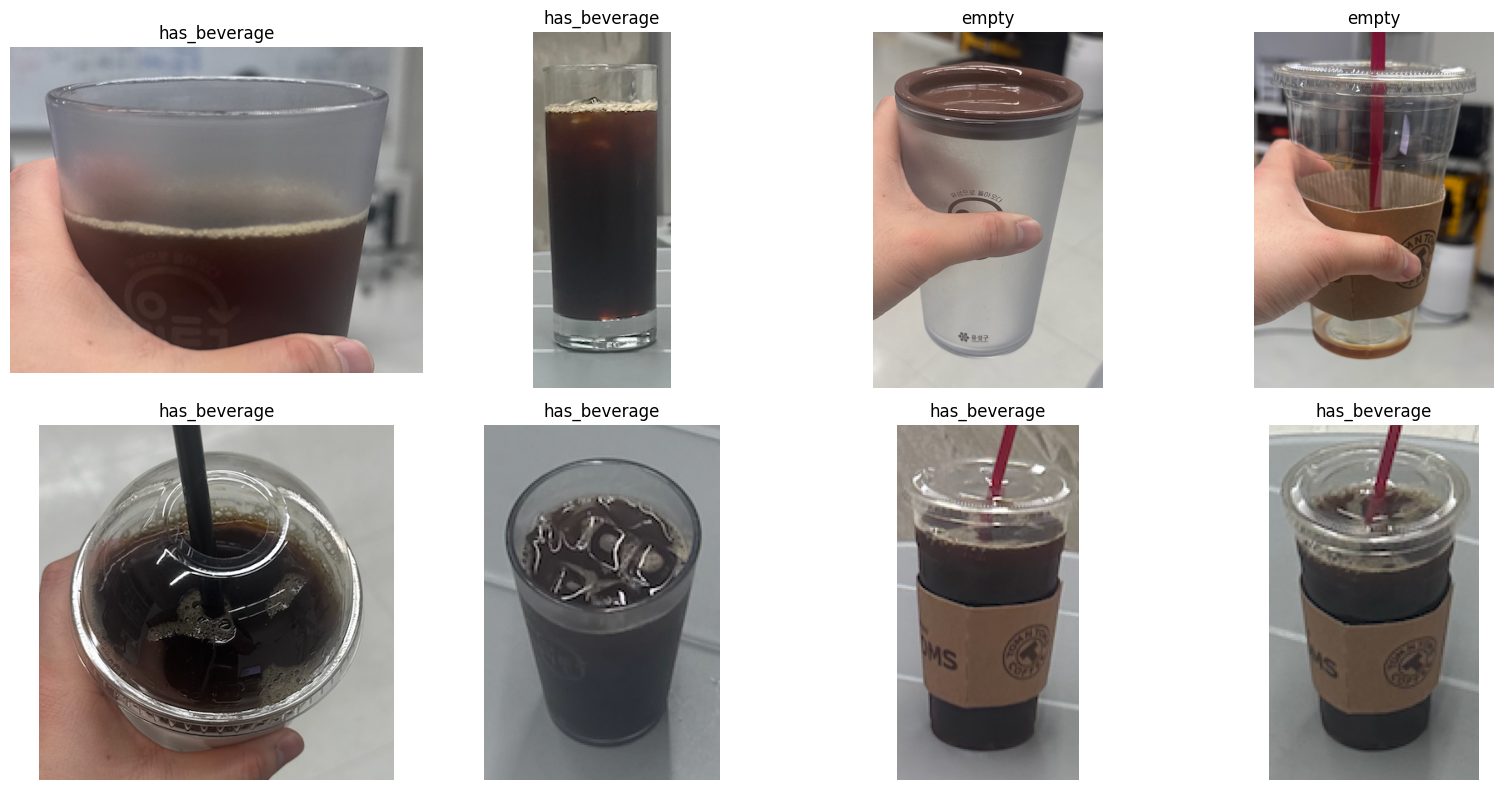

In [7]:
# 샘플 이미지 시각화
def show_samples(dataset, n_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i in range(min(n_samples, len(dataset))):
        img_path, label = dataset.dataset.samples[dataset.indices[i]]
        img = Image.open(img_path)
        
        axes[i].imshow(img)
        axes[i].set_title(f"{CLASSES[label]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Training samples:")
show_samples(train_dataset)

## 7. 모델 정의

In [8]:
class BeverageDetector(nn.Module):
    """음료 여부 검증 모델 (EfficientNet-B0 기반)"""
    
    def __init__(self, num_classes=2, pretrained=True):
        super(BeverageDetector, self).__init__()
        
        # EfficientNet-B0 백본
        self.backbone = models.efficientnet_b0(pretrained=pretrained)
        
        # 마지막 FC layer 교체
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

# 모델 생성
model = BeverageDetector(num_classes=NUM_CLASSES, pretrained=True)
model = model.to(device)

print(f"Model created and moved to {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model created and moved to cuda
Total parameters: 4,010,110
Trainable parameters: 4,010,110


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 8. Loss, Optimizer, Scheduler 설정

In [9]:
# 클래스 가중치 계산 (불균형 데이터 대응)
class_counts = [0] * NUM_CLASSES
for _, label in train_dataset:
    class_counts[label] += 1

class_weights = [len(train_dataset) / count for count in class_counts]
class_weights = torch.FloatTensor(class_weights).to(device)

print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

print("Loss, optimizer, and scheduler configured")

Class counts: [34, 102]
Class weights: tensor([4.0000, 1.3333], device='cuda:0')
Loss, optimizer, and scheduler configured


## 9. 학습 및 검증 함수

In [10]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """1 epoch 학습"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    """1 epoch 검증"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

print("Training and validation functions defined")

Training and validation functions defined


## 10. 학습 루프

In [11]:
# 학습 히스토리 저장
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_loss = float('inf')
best_val_acc = 0.0
patience_counter = 0

print("Starting training...\n")

for epoch in range(EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"{'='*60}")
    
    # 학습
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # 검증
    val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # 히스토리 저장
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # 결과 출력
    print(f"\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Best model 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        patience_counter = 0
        
        # 모델 저장
        save_path = MODEL_SAVE_DIR / 'beverage_detector_best.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_acc': val_acc,
        }, save_path)
        print(f"✅ Best model saved! (Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%)")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{PATIENCE}")
    
    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\n⚠️ Early stopping triggered after {epoch+1} epochs")
        break

print(f"\n{'='*60}")
print("Training completed!")
print(f"Best Val Loss: {best_val_loss:.4f}")
print(f"Best Val Acc: {best_val_acc:.2f}%")
print(f"{'='*60}")

Starting training...


Epoch [1/50]


Training:  11%|█         | 1/9 [00:00<00:06,  1.21it/s, loss=0.8482, acc=43.75%]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 5.60 GiB of which 38.50 MiB is free. Process 489 has 3.20 GiB memory in use. Including non-PyTorch memory, this process has 1.53 GiB memory in use. Of the allocated memory 1.38 GiB is allocated by PyTorch, and 21.83 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## 11. 학습 곡선 시각화

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss 곡선
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy 곡선
ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig(MODEL_SAVE_DIR / 'beverage_detector_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. 최종 모델 평가

In [ ]:
# Best model 로드
checkpoint = torch.load(MODEL_SAVE_DIR / 'beverage_detector_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Best model loaded (Epoch {checkpoint['epoch']+1})")

# 최종 평가
val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)

print(f"\nFinal Validation Results:")
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_acc:.2f}%")

# Classification Report
print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(val_labels, val_preds, target_names=CLASSES, digits=4))

## 13. Confusion Matrix 시각화

In [ ]:
# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Beverage Detector')
plt.tight_layout()
plt.savefig(MODEL_SAVE_DIR / 'beverage_detector_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES,
            cbar_kws={'label': 'Percentage'})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix - Beverage Detector')
plt.tight_layout()
plt.savefig(MODEL_SAVE_DIR / 'beverage_detector_confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

## 14. 학습 메타데이터 저장

In [ ]:
# 메타데이터 저장
metadata = {
    'model_name': 'beverage_detector',
    'architecture': 'EfficientNet-B0',
    'num_classes': NUM_CLASSES,
    'classes': CLASSES,
    'img_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'epochs_trained': len(history['train_loss']),
    'learning_rate': LEARNING_RATE,
    'best_val_loss': best_val_loss,
    'best_val_acc': best_val_acc,
    'train_samples': len(train_dataset),
    'val_samples': len(val_dataset),
    'class_counts': class_counts,
}

with open(MODEL_SAVE_DIR / 'beverage_detector_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("Metadata saved to beverage_detector_metadata.json")
print(json.dumps(metadata, indent=2))

## 15. 샘플 예측 시각화

In [ ]:
# 샘플 예측 시각화
model.eval()

# 샘플 선택 (validation set에서)
n_samples = 8
sample_indices = np.random.choice(len(val_dataset), n_samples, replace=False)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, idx in enumerate(sample_indices):
    img_path, true_label = val_dataset.dataset.samples[val_dataset.indices[idx]]
    img = Image.open(img_path).convert('RGB')
    
    # 예측
    img_tensor = val_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)
        pred_label = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_label].item()
    
    # 시각화
    axes[i].imshow(img)
    color = 'green' if pred_label == true_label else 'red'
    axes[i].set_title(
        f"True: {CLASSES[true_label]}\nPred: {CLASSES[pred_label]} ({confidence*100:.1f}%)",
        color=color
    )
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(MODEL_SAVE_DIR / 'beverage_detector_sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

## 완료!

음료 여부 검증 모델 학습이 완료되었습니다.

### 저장된 파일:
- `models/weights/beverage_detector_best.pth` - 최고 성능 모델
- `models/weights/beverage_detector_metadata.json` - 모델 메타데이터
- `models/weights/beverage_detector_*.png` - 학습 곡선, confusion matrix 등